In [2]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "12_generation/12c_gan.ipynb"
_nb_title = "GANs"
_nb_message = """
MNIST에 대해 바닐라 GAN과 심층 컨볼루션 GAN을 훈련.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/ychoi-kr/practical-ml-vision-book-ko/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>AI Platform Notebook에서 실행</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Google Colab에서 실행</a></td><td><a target="_blank" href="{2}"><img src="{6}" />GitHub에서 소스 보기</a></td><td><a href="{3}"><img src="{7}" />노트북 내려받기</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=GANs&download_url=https%3A%2F%2Fgithub.com%2Fychoi-kr%2Fpractical-ml-vision-book-ko%2Fraw%2Fmaster%2F12_generation%2F12c_gan.ipynb"><img src="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png"/>AI Platform Notebook에서 실행</a></td><td><a target="_blank" href="https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/12_generation/12c_gan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Google Colab에서 실행</a></td><td><a target="_blank" href="https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/12_generation/12c_gan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />GitHub에서 소스 보기</a></td><td><a href="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/12_generation/12c_gan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />노트북 내려받기</a></td></table><br/><br/><h1>GANs</h1>
MNIST에 대해 바닐라 GAN과 심층 컨볼루션 GAN을 훈련.


# 생성적 적대 네트워크 (GANs: Generative Adversarial Networks)

## GPU 활성화
이 저장소의 노트북들은 GPU를 사용하면 더 빨리 실행된다. 

코랩에서:
* 수정 → 노트 설정 메뉴로 이동
* 하드웨어 가속기 드롭다운에서 GPU를 선택

Cloud AI Platform Notebooks에서:
* https://console.cloud.google.com/ai-platform/notebooks 로 이동
* GPU를 포함한 인스턴스를 생성하거나, 인스턴스를 선택하고 GPU를 추가

다음으로, 텐서플로로 GPU에 연결할 수 있는지 확인.

In [1]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.9.2
Found GPU at: /device:GPU:0


In [3]:
# 라이브러리와 모듈을 임포트
import matplotlib.pyplot as plt
import numpy as np
print(np.__version__)
np.set_printoptions(threshold=np.inf)

1.21.6


## 바닐라 GAN

바닐라(vanilla) GAN에서는 생성기와 판별기에 기본 `Dense` 레이어를 사용한다.

In [4]:
# 생성기 만들기.
latent_dim = 512
vanilla_generator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(units=256),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(units=28 * 28 * 1, activation="tanh"),
        tf.keras.layers.Reshape(target_shape=(28, 28, 1))
    ],
    name="vanilla_generator"
)
vanilla_generator.summary()

Model: "vanilla_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)         

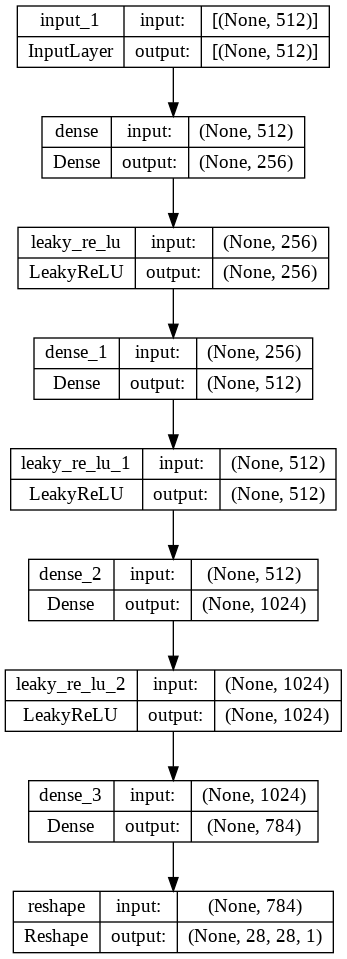

In [5]:
# 생성기 모델을 플롯
tf.keras.utils.plot_model(
    model=vanilla_generator,
    to_file="vanilla_generator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [6]:
# 판별기 만들기.
vanilla_discriminator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(units=256),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(units=1),
    ],
    name="vanilla_discriminator"
)
vanilla_discriminator.summary()

Model: "vanilla_discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)     

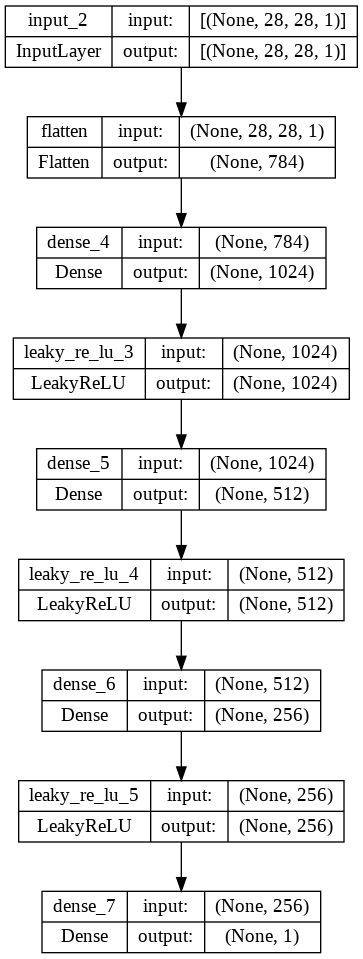

In [7]:
# 판별기 모델을 플롯.
tf.keras.utils.plot_model(
    model=vanilla_discriminator,
    to_file="vanilla_discriminator_model.png",
    show_shapes=True,
    show_layer_names=True
)

생성기 및 판별기 네트워크의 교육을 용이하게 하는 데 사용할 수 있는 `GAN`이라는 사용자 지정 `Model` 클래스를 작성한다.

In [8]:
class GAN(tf.keras.Model):
    """GAN 훈련을 위한 맞춤 모델.

    Attributes:
        discriminator: Keras `Model`, 판별기 네트워크.
        generator: Keras `Model`, 생성기 네트워크.
        latent_dim: int, 잠재 벡터 차원 길이.
        one_sided_label_smoothing: float, [0., 1.]의 값으로 실제 이미지 레이블을 얼마나 매끄럽게 할 것인지.
        discriminator_optimizer: Keras `Optimizer`, 판별기 네트워크의 옵티마이저.
        generator_optimizer: Keras `Optimizer`, 생성기 네트워크의 옵티마이저.
        loss_fn: Keras `Loss`, 훈련 네트워크들의 손실 함수.
    """
    def __init__(
        self, discriminator, generator, latent_dim, one_sided_label_smoothing
    ):
        """`GAN` 모델 클래스를 인스턴스화.

        Args:
            discriminator: Keras `Model`, 판별기 네트워크.
            generator: Keras `Model`, 생성기 네트워크.
            latent_dim: int, 잠재 벡터 차원 길이.
            one_sided_label_smoothing: float, [0., 1.]의 값으로 실제 이미지 레이블을 얼마나 매끄럽게 할 것인지.
        """
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.one_sided_label_smoothing = one_sided_label_smoothing

    def compile(self, discriminator_optimizer, generator_optimizer, loss_fn):
        """기본 `Model` 클래스의 compile 메서드를 오버라이드.

        Args:
            discriminator_optimizer: Keras `Optimizer`, 판별기 네트워크의 옵티마이저.
            generator_optimizer: Keras `Optimizer`, 생성기 네트워크의 옵티마이저.
            loss_fn: Keras `Loss`, 훈련 네트워크들의 손실 함수.
        """
        super(GAN, self).compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.loss_fn = loss_fn

    def discriminator_train_step(self, batch_size, real_images):
        """판별기를 한 스텝 훈련.

        Args:
            batch_size: tensor, 미니 배치의 요소 수를 나타내는 스칼라 텐서.
            real_images: tensor, 모양이 (batch_size, height, width, depth)인 실제 이미지의 4계 텐서.

        Returns:
            discriminator_loss: tensor, 판별기 스텝의 스칼라 손실.
        """
        # 잠재 공간에서 무작위 포인트를 샘플링.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # 노이즈에서 이미지를 생성.
        generated_images = self.generator(inputs=random_latent_vectors)

        # 생성된 이미지를 실제 이미지와 결합.
        combined_images = tf.concat(
            values=[generated_images, real_images], axis=0
        )

        # 가짜 및 실제 레이블을 만듦.
        fake_labels = tf.zeros(shape=(batch_size, 1))
        real_labels = tf.ones(shape=(batch_size, 1))

        # 학습에 도움이 되도록 실제 레이블을 매끄럽게 함.
        real_labels *= self.one_sided_label_smoothing

        # 결합된 이미지와 인라인이 되도록 라벨을 결합.
        labels = tf.concat(
            values=[fake_labels, real_labels], axis=0
        )

        # 판별기만 훈련.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(inputs=combined_images)
            discriminator_loss = self.loss_fn(
                y_true=labels, y_pred=predictions
            )

        grads = tape.gradient(
            target=discriminator_loss,
            sources=self.discriminator.trainable_weights
        )

        self.discriminator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.discriminator.trainable_weights)
        )

        return discriminator_loss

    def generator_train_step(self, batch_size):
        """생성기를 한 스텝 훈련.

        Args:
            batch_size: tensor, 미니 배치의 요소 수를 나타내는 스칼라 텐서.

        Returns:
            generator_loss: tensor, 생성기 스텝의 스칼라 손실.
        """
        # 잠재 공간에서 무작위 포인트를 샘플링.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # 실제 이미지인 것처럼 레이블을 만듦.
        labels = tf.ones(shape=(batch_size, 1))

        # 생성기만 훈련.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                inputs=self.generator(inputs=random_latent_vectors)
            )
            generator_loss = self.loss_fn(y_true=labels, y_pred=predictions)

        grads = tape.gradient(
            target=generator_loss, sources=self.generator.trainable_weights
        )

        self.generator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.generator.trainable_weights)
        )

        return generator_loss

    def train_step(self, real_images):
        """Trains `GAN` for one step.

        Args:
            real_images: tensor, 모양이 (batch_size, height, width, depth)인 실제 이미지의 4계 텐서.

        Returns:
            losses: dict, 각 하위 훈련 단계의 손실 딕셔너리리.
        """
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # 랜덤 노이즈 벡터에 사용할 동적 배치 크기를 가져옴.
        batch_size = tf.shape(input=real_images)[0]

        # 먼저 판별기를 훈련련.
        discriminator_loss = self.discriminator_train_step(
            batch_size, real_images
        )

        # 다음으로 생성기를 훈련.
        generator_loss = self.generator_train_step(batch_size)

        losses = {
            "discriminator_loss": discriminator_loss,
            "generator_loss": generator_loss
        }

        return losses


In [9]:
def create_train_dataset(batch_size):
    """훈련 데이터셋 생성.

    Args:
        batch_size: int, 미니배치의 요소 수.

    Returns:
        dataset: `Dataset`, MNIST를 사용한 훈련의 데이터셋 객체.
    """
    # MNIST 데이터를 로딩
    (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

    # 훈련셋과 테스트셋을 조합.
    combined = np.concatenate([x_train, x_test])
    combined = (combined.astype("float32") - 127.5) / 255.0
    combined = np.reshape(combined, newshape=(-1, 28, 28, 1))

    # 훈련을 위해 tf.data.Dataset 생성.
    dataset = tf.data.Dataset.from_tensor_slices(tensors=combined)
    dataset = dataset.shuffle(buffer_size=70000).batch(batch_size=batch_size)

    return dataset


In [10]:
# 바닐라 생성기와 판별자를 사용하여 GAN 인스턴스를 인스턴스화.
vanilla_gan = GAN(
    discriminator=vanilla_discriminator,
    generator=vanilla_generator,
    latent_dim=latent_dim,
    one_sided_label_smoothing=0.9
)

vanilla_gan.compile(
    discriminator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    generator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

# 바닐라 GAN 모델을 훈련.
vanilla_gan_history = vanilla_gan.fit(
    create_train_dataset(batch_size=128), epochs=30
)

11490434/11490434 [==============================] - 2s 0us/step
Epoch 1/30
547/547 [==============================] - 6s 6ms/step - discriminator_loss: 0.6203 - generator_loss: 1.3620
Epoch 2/30
547/547 [==============================] - 3s 6ms/step - discriminator_loss: 0.6031 - generator_loss: 1.3520
Epoch 3/30
547/547 [==============================] - 3s 6ms/step - discriminator_loss: 0.5867 - generator_loss: 1.3310
Epoch 4/30
547/547 [==============================] - 4s 7ms/step - discriminator_loss: 0.6035 - generator_loss: 1.2584
Epoch 5/30
547/547 [==============================] - 4s 8ms/step - discriminator_loss: 0.6057 - generator_loss: 1.2234
Epoch 6/30
547/547 [==============================] - 3s 5ms/step - discriminator_loss: 0.6049 - generator_loss: 1.2335
Epoch 7/30
547/547 [==============================] - 3s 5ms/step - discriminator_loss: 0.6010 - generator_loss: 1.2537
Epoch 8/30
547/547 [==============================] - 4s 7ms/step - discriminator_loss: 0.5985 

Let's plot the loss history and some generated images using our trained model.

In [11]:
def plot_loss_history(history):
    """손실 히스토리를 플롯.

    Args:
        history: `keras.callbacks.History`, 훈련 작업의 히스토리 객체.
    """
    plt.plot(history.history["generator_loss"])
    plt.plot(history.history["discriminator_loss"])
    plt.title("Training losses")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["generator", "discriminator"], loc="upper left")
    plt.show()


In [12]:
def plot_images(images):
    """이미지를 플롯.

    Args:
        images: np.array, [num_images, image_size, image_size, num_channels]의 이미지의 배열.
    """
    num_images = len(images)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        image = images[i]
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            tf.reshape(image, image.shape[:-1]),
            cmap="gray_r"
        )
    plt.show()

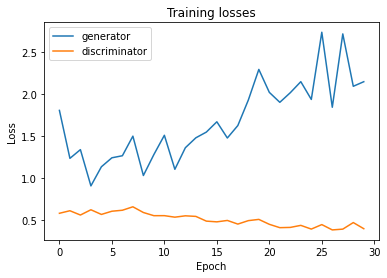

In [13]:
plot_loss_history(history=vanilla_gan_history)

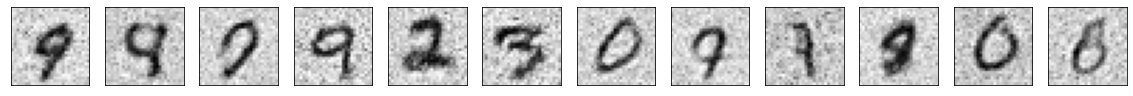

In [14]:
plot_images(
    images=vanilla_gan.generator(
        inputs=tf.random.normal(shape=(12, latent_dim))
    )
)

## DCGAN

DCGAN(Deep-convolutional GAN)은 판별자와 생성자에 대해 각각 `Dense` 레이어 대신 컨볼루션(`Conv2D`) 및 디컨볼루션(`Conv2DTranspose`)을 사용한다.

In [15]:
# 생성기 만들기
def create_generator_block(filters, kernel_size, strides, padding, alpha):
    """레이어의 생성기 블록을 만듦.

    Args:
        filters: int, 출력 필터/채널 수.
        kernel_size: int/2-tuple of ints, 커널의 높이와 너비.
        strides: int/2-tuple of ints, 슬라이딩 윈도의 각 보폭의 높이와 너비.
        padding: str, 출력의 패딩 유형: same 또는 valid.
        alpha: float, LeakyRelu 활성화의 누출 정도.

    Returns:
        레이어의 리스트.
    """
    return [
        tf.keras.layers.Conv2DTranspose(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=alpha)
    ]

def create_dcgan_generator(latent_dim):
    """심층 컨벌루션 GAN 생성기 네트워크를 만듦.

    Args:
        latent_dim: int, 잠재 벡터 차원 길이.

    Returns:
        Keras 순차형 모델.
    """
    dcgan_generator = [
        tf.keras.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(units=7 * 7 * 256),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
    ] + create_generator_block(
        filters=128, kernel_size=4, strides=2, padding="same", alpha=0.2
    ) + create_generator_block(
        filters=128, kernel_size=4, strides=2, padding="same", alpha=0.2
    ) + [
        tf.keras.layers.Conv2DTranspose(
            filters=1,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="tanh"
        )
    ]

    return tf.keras.Sequential(layers=dcgan_generator, name="dcgan_generator")

dcgan_generator = create_dcgan_generator(latent_dim=512)
dcgan_generator.summary()

Model: "dcgan_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 12544)             6435072   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      524416    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 14, 128)   

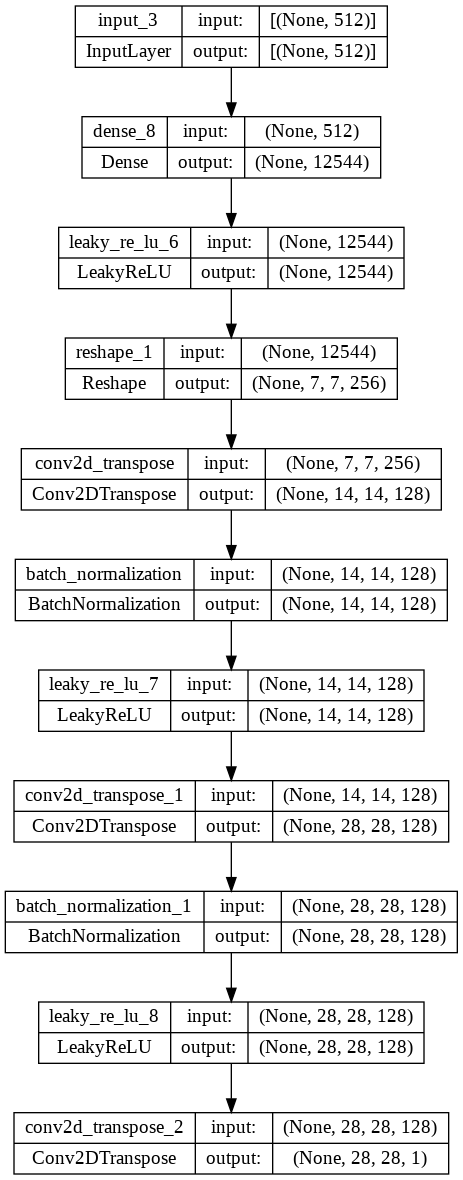

In [16]:
# 생성기 모델을 플롯.
tf.keras.utils.plot_model(
    model=dcgan_generator,
    to_file="dcgan_generator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [17]:
# 판별기 만들기
def create_discriminator_block(filters, kernel_size, strides, padding, alpha):
    """레이어의 판별자 블록을 만듦.

    Args:
        filters: int, 출력 필터/채널 수.
        kernel_size: int/2-tuple of ints, 커널의 높이와 너비.
        strides: int/2-tuple of ints, 슬라이딩 윈도의 각 보폭의 높이와 너비.
        padding: str, 출력의 패딩 유형: same 또는 valid.
        alpha: float, LeakyRelu 활성화의 누출 정도.

    Returns:
        레이어 리스트.
    """
    return [
        tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=alpha)
    ]

def create_dcgan_discriminator(input_shape):
    """심층 컨볼루션 GAN 판별 네트워크를 만듦.

    Args:
        input_shape: tuple, 배치 차원이 없는 입력의 모양.

    Returns:
        Keras 순차형 모델.
    """
    dcgan_discriminator = [
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(
            filters=64, kernel_size=3, strides=1, padding="same"
        ),
        tf.keras.layers.LeakyReLU(alpha=0.2)
    ] + create_discriminator_block(
        filters=128, kernel_size=3, strides=2, padding="same", alpha=0.2
    ) + create_discriminator_block(
        filters=128, kernel_size=3, strides=2, padding="same", alpha=0.2
    ) + create_discriminator_block(
        filters=256, kernel_size=3, strides=2, padding="same", alpha=0.2
    ) + [
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1)
    ]

    return tf.keras.Sequential(layers=dcgan_discriminator, name="dcgan_discriminator")

dcgan_discriminator = create_dcgan_discriminator(input_shape=(28, 28, 1))
dcgan_discriminator.summary()

Model: "dcgan_discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         147584    
                                               

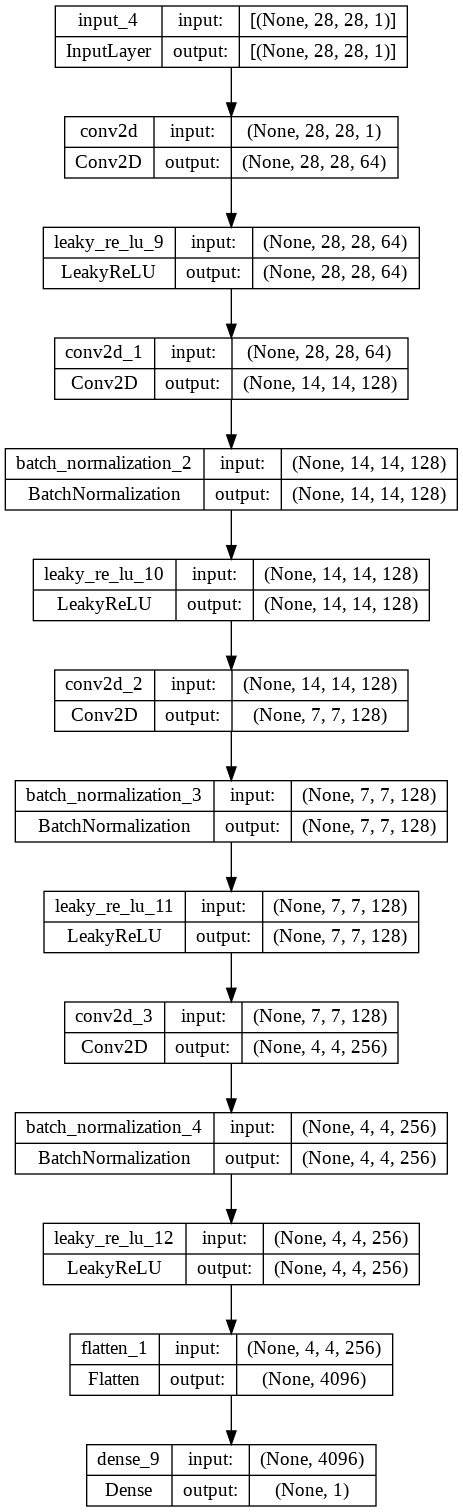

In [18]:
# 생성기 모델을 플롯.
tf.keras.utils.plot_model(
    model=dcgan_discriminator,
    to_file="dcgan_discriminator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [19]:
# DCGAN 생성기와 판별자를 사용하여 GAN 인스턴스를 인스턴스화.
dcgan = GAN(
    discriminator=dcgan_discriminator,
    generator=dcgan_generator,
    latent_dim=latent_dim,
    one_sided_label_smoothing=0.9
)

dcgan.compile(
    discriminator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    generator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

# DCGAN 모델을 훈련.
dcgan_history = dcgan.fit(create_train_dataset(batch_size=128), epochs=50)

Epoch 1/50
547/547 [==============================] - 57s 90ms/step - discriminator_loss: 0.5193 - generator_loss: 1.4416
Epoch 2/50
547/547 [==============================] - 49s 89ms/step - discriminator_loss: 0.4233 - generator_loss: 1.9998
Epoch 3/50
547/547 [==============================] - 49s 90ms/step - discriminator_loss: 0.4259 - generator_loss: 2.0135
Epoch 4/50
547/547 [==============================] - 50s 92ms/step - discriminator_loss: 0.4254 - generator_loss: 1.9870
Epoch 5/50
547/547 [==============================] - 52s 95ms/step - discriminator_loss: 0.4447 - generator_loss: 1.8767
Epoch 6/50
547/547 [==============================] - 53s 96ms/step - discriminator_loss: 0.4598 - generator_loss: 1.7975
Epoch 7/50
547/547 [==============================] - 52s 95ms/step - discriminator_loss: 0.4590 - generator_loss: 1.7977
Epoch 8/50
547/547 [==============================] - 51s 94ms/step - discriminator_loss: 0.4679 - generator_loss: 1.7257
Epoch 9/50
547/547 [====

훈련된 모델을 사용해 손실 히스토리와 일부 생성된 이미지를 플로팅해 보자.

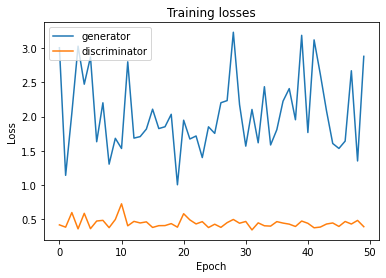

In [20]:
plot_loss_history(history=dcgan_history)

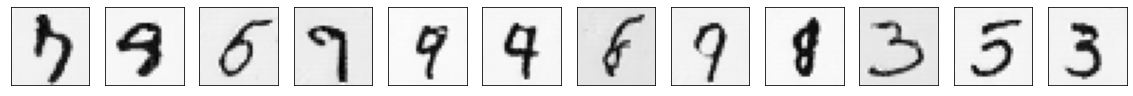

In [21]:
plot_images(
    images=dcgan.generator(inputs=tf.random.normal(shape=(12, latent_dim)))
)